In [1]:
from gym import Env
from gym.envs.registration import EnvSpec
import numpy as np
from gym.spaces import MultiDiscrete,Box
from graph_tool.all import *
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from makegraph import *
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def simulatepandemic(self,actions):
    action = np.divide(actions,np.sum(actions)) #relative availability of vaccine is calculated
    update_state(self.g,action)
    erate = extract_economy(self.g)
    self.state = graph_to_matrix(self.g)
    self.timestep += 1
    return self.state

def initializepandemic(self):
    self.g = make_graph(self.size,self.distribution)
    self.state = graph_to_matrix(self.g)
    return self.state

In [3]:
#the class is needed if we want to sample more frequently
from stable_baselines3.common.callbacks import BaseCallback
'''
https://github.com/DLR-RM/stable-baselines3/issues/309

^^^^^^ this was very helpful ^^^^^^
'''
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=1):
        super(TensorboardCallback, self).__init__(verbose)
        self.cum_rew_1 = 0
        #self.rew_1 = 0
        
    def _on_rollout_end(self) -> None:
        self.logger.record("rollout/cum_rew_1", self.cum_rew_1)
        #self.logger.record("rollout/rew_1", self.rew_1)
        # reset var once recorded
        self.cum_rew_1 = 0
        self.rew_1 = 0
        

    def _on_step(self) -> bool:
        # Log scalar value (here a random variable)
        #value = np.random.random()
        #self.logger.record('random_value', value)
        
        #self.logger.dump(self.num_timesteps)
        self.cum_rew_1 += self.training_env.get_attr("reward")[0]
        #self.rew_1 = self.training_env.get_attr("reward_1")[0]
        return True

In [4]:

class PanEnv(Env):
    def __init__(self,size,distribution):
        self.size = size #population size
        self.spec = EnvSpec('GymEnv-v0')
        self.action_space = MultiDiscrete(nvec=[10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10])
        self.observation_space = Box(low=-np.inf,high=np.inf,shape=[self.size,7])
        
        
        self.distribution = distribution #age distribution, country name as string
        self.g = make_graph(self.size,self.distribution)
                
        #state observation as matrix
        self.state = graph_to_matrix(self.g)
        
        self.timestep = 1
    def step(self,actions):
    
        
        state = simulatepandemic(self,actions)
        E_t = np.sum(state[:,0])+np.sum(state[:,2])+np.sum(state[:,3])
        #observation (object): agent's observation of the current environment
        #r ans s taken from nature paper
        r = 8
        s = 5
        
        total_population = self.size
        
        active_cases = np.sum(state[:,1])+np.sum(state[:,4])
        #A_t and D_t from nature paper
        
        A_t = (active_cases/total_population) * 100
        
        D_t = np.sum(state[:,5])/total_population
        #self.reward_1 =  E_t * np.exp(-r * A_t) - s * D_t
        
        reward = E_t/total_population
        
       
        #print(reward)
        #reward (float) : amount of reward returned after previous action
        #negative reward: punishment > change weights a lot, push away from causing weights, positive rewards pull
        #do reward compared to reward from previous step
        #naive example: reward = -sum(infected) > we want a reward where the cumulative sum of infections until end
        #is minimized
        #exp. solution: store informatiop_n in self, summed infections, normalized by time
        done = False
        if((self.timestep > 19) or np.sum(self.state[:,1])==0):
            done = True
        #done (bool): episode is done after 20 timesteps or when there are no longer infected agents
        info = {}
        #info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)'''
        return state, reward, done, info
    def reset(self):
        #returns initial state
        self.state = initializepandemic(self)
        return self.state

In [5]:
from stable_baselines3.common.env_checker import check_env
#check_env(Env)

In [6]:
#matrix representation:
#[S, I, R, Sv, Iv, D]

In [7]:
env = PanEnv(size=1000,distribution='Japan')
env.reset()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [8]:
actions = np.full(20,1)

In [9]:
env.step(actions)

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 0.955,
 False,
 {})

In [10]:
print(np.sum(env.state[:,0]),np.sum(env.state[:,1]),np.sum(env.state[:,2]),np.sum(env.state[:,3]),np.sum(env.state[:,4]),)

914.0 44.0 0.0 41.0 0.0


In [11]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

#tensorflow for graphs
import tensorflow as tf
from stable_baselines3.common.evaluation import evaluate_policy
env = PanEnv(size=100,distribution='Japan')
log_dir = "./gym/"
env = Monitor(env,log_dir)
model = PPO("MlpPolicy",env,verbose=1)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

2021-12-03 17:13:46.582901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 17:13:46.582921: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Using cpu device
Wrapping the env in a DummyVecEnv.


In [12]:
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:1.00 +/- 0.58


In [13]:

# Parallel environments

env = DummyVecEnv([lambda: Monitor(PanEnv(size=100,distribution='Japan'),log_dir)])

In [14]:
#env = Monitor(env,log_dir)
model = PPO("MlpPolicy", env, verbose=1,tensorboard_log="./ppo_name_tensorboard/") #multilayer

#model = PPO("MlpPolicy", env, verbose=1) #multilayer
rewards_callback = TensorboardCallback()
model.learn(total_timesteps=25000,tb_log_name="first_run") #training loop
#model.learn(total_timesteps=25000) #training loop

#model.save("Japan_death")

#del model # remove to demonstrate saving and loading

#Japan_death = PPO.load("Japan_death")
#https://stable-baselines.readthedocs.io/en/master/guide/tensorboard.html?highlight=tensorboard
#^^^ tensorboard for displaying things, but I am stuck, upd: i guess it works now ^^^

Using cpu device
Logging to ./ppo_name_tensorboard/first_run_67
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.92     |
| time/              |          |
|    fps             | 67       |
|    iterations      | 1        |
|    time_elapsed    | 30       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1           |
|    ep_rew_mean          | 0.907       |
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 2           |
|    time_elapsed         | 64          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.038048334 |
|    clip_fraction        | 0.355       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46         |
|    exp

In [22]:
model.save("Japan_economy_reward")
mean_reward, std_reward = evaluate_policy(model, env,n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.90 +/- 0.11


In [16]:
model = PPO("MlpPolicy", env, verbose=1,tensorboard_log="./ppo_name_tensorboard/") #multilayer
mean_reward, std_reward = evaluate_policy(model, env=PanEnv(size=100,distribution='Japan'), n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Using cpu device


/home/artem/anaconda3/envs/pandemic/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:1.03 +/- 0.64


In [17]:
#after training, reward should have improved
mean_reward, std_reward = evaluate_policy(Japan_death, env=PanEnv(size=100,distribution='Japan'), n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

NameError: name 'Japan_death' is not defined

In [20]:
#model.save("Japan_death")
Japan_death = PPO.load("Japan_economy_reward")

In [66]:
env = PanEnv(size=100,distribution='Japan')
#after training, reward should have improved
log_dir = "./gym/"
env = Monitor(env,log_dir)
mean_reward, std_reward = evaluate_policy(Japan_death, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:1.01 +/- 0.51


In [68]:
env = PanEnv(size=100,distribution='Japan')
obs = env.reset()
done = False
obs_storage = []
rewards_storage = []
action_storage = []


while not done:
    action, _states = Japan_death.predict(obs)
    
    
    obs, rewards, done, info = env.step(action)
    obs_storage.append(obs)
    infected = np.nonzero(obs[:,1])
    l=np.size(infected)/100
    print (l)
    rewards_storage.append(rewards)
    action_storage.append(action)

0.1
0.23
0.29
0.12
0.03
0.0


In [64]:
def get_sums(obs,index):
    sums = []
    for i in np.arange(0,len(obs)):
        sums.append(np.sum(obs_storage[i][:,index]))
    return sums
def show_pandemic(obs):
    all_sums = []
    for i in np.arange(0,7):
        all_sums.append(get_sums(obs,i))
    sval,ival,rval,vsval,vival,dval,economy_list = all_sums[0],all_sums[1],all_sums[2],all_sums[3],all_sums[4],all_sums[5],all_sums[6]
    tlist = np.arange(0,len(obs))
    plt.figure()
    plt.plot(tlist, sval, label = "S")
    plt.plot(tlist, rval, label = "R")
    plt.plot(tlist, vsval, label = "Sv")
    plt.plot(tlist, vival, label = "Iv")
    plt.plot(tlist, ival, label = "I")
    plt.plot(tlist, dval, label = "D")
    plt.plot(tlist,economy_list, label = "Economy")
    plt.legend()
    plt.show()
def show_actions(actions):
    eps = len(actions)
    
    color_pos = np.linspace(0,1,eps)
    cmap = mpl.cm.get_cmap('inferno')
    colors = [cmap(pos) for pos in color_pos]
    
    
    plt.figure()
    for i in np.arange(0,eps):
        #hist = np.histogram(actions[i],bins = np.linspace(1,21,20))
        plt.plot(np.linspace(1,21,20),actions[i]/np.sum(actions[i]),color=colors[i],label='t = str(i)')
    plt.show()

In [43]:
print(len(action_storage))

4


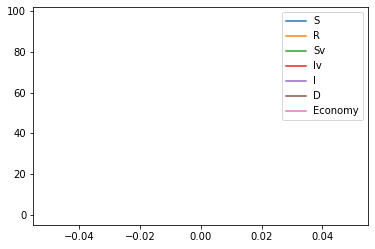

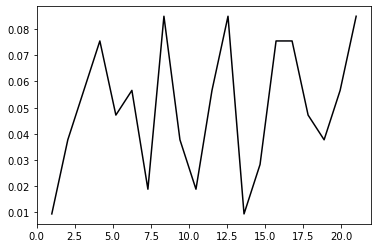

In [32]:
show_pandemic(obs_storage)
show_actions(action_storage)

In [ ]:
#split into learning and testing
model.learn(total_timesteps = 5000)
# store/accumulate rewards